# Homework 4

## Question 7.1

My job is constantly analyzing the number of views for our television network. Looking at both the number of viewers minute by minute in each program, or even the average viewers over the year, could benefit from exponential smoothing.  
When looking at prime time (8pm - 11pm) audience over a year, we would need the average number of viewers for each day's telecasts during prime time. A useful goal of this would be in looking at the trend, similar to change detection, to see how viewership evolves for our network over the seasons. Instead of determining change, however, we often aim to project for the number of viewers.  
  
The alpha value really depends on what time period we are looking at.  
Ratings follow a very loosely cyclic pattern. Ratings rise as premium shows are released, and slowly fall off until the next season start. When projecting for the program's total viewership during its air time, we would want alpha to be closer to 1 simply because most programs lose viewers over time.  
If we are looking at the network's total viewers over the entire year, we may want to use a value closer to 0. This is because while each show might lose viewers over time, many days have random spikes of views that are hard to explain. Another cause for exceptional spikes would be premium program premieres. When running dozens of programs, and also accounting for the unreliability of individual program successes, we would have many spikes in the data per day.  

## Question 7.2

In [1]:
df.raw <- read.table('temps.txt', header=TRUE)
df.temp <- data.frame(df.raw[,-1], row.names = df.raw[,1])

Let us start by trying to see what the Holt Winters method is all about.  
Since we need a time series data to do this, we can use the mean of temperature of each year.

In [2]:
# Mean temp of each year
df.means <- data.frame(colMeans(df.temp))

In [3]:
# Holt Winters
# beta: FALSE - apply exponential smoothing
# gamma: FALSE - not seasonal
hs.example <- HoltWinters(ts(df.means),
                  alpha=0.3,
                  beta=FALSE,
                  gamma=FALSE)

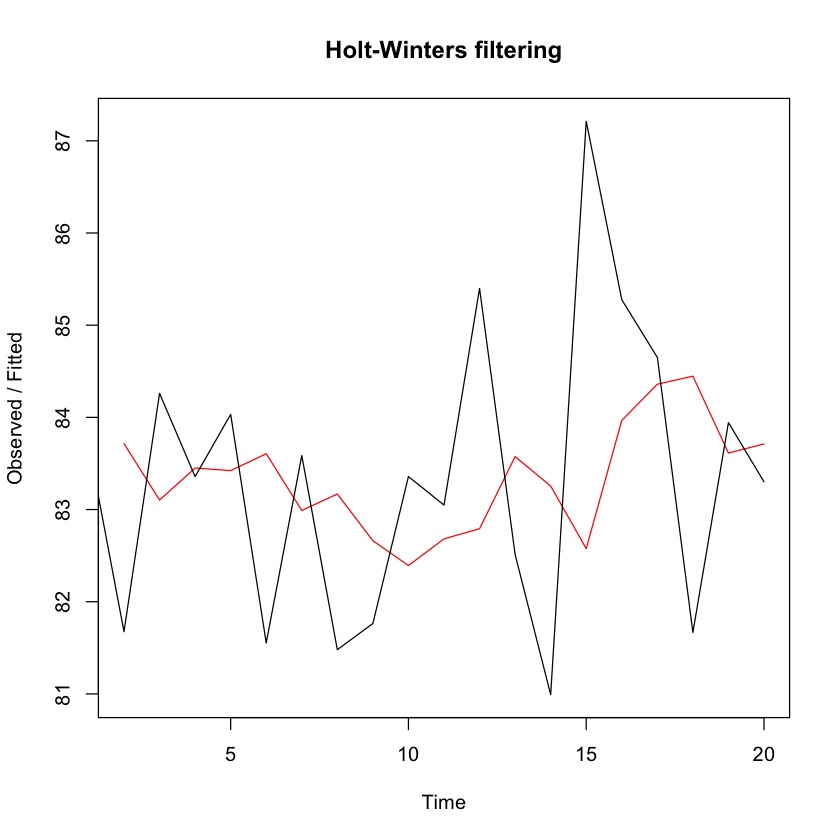

In [4]:
plot(hs.example)

With this, can we determine that the average temperature has risen?  
Forgetting preconcieved notions of global climate change over hundreds of years, it seems hard to tell. But this is the idea that we would use for a change in summer's end date. The strategy for now will be to determine the end of summer for each year, so that we can apply Holt Winter's method as shown above.

### Preliminary CUSUM Functions

We will use these functions to determine the end of summer.  
The "get_cusum" function will let us find the cusum values for a vector for a chosen lambda value, C. The "get_dates" will find the date of summer's unofficial end for a chosen threshold value, T.  
  
Building these functions that loop through data for us will help try out different combinations to determine the end of summer. This is important since determining a change in the end of summer really depends on how we classify the end to a summer.  

In [5]:
# Get the cumulative sum iterations for a vector, d
get_cusum <- function(d, c=0.5*sd(d)) {
    u <- mean(d)
    s <- c(0)
    # Use formula for detecting decrease
    for (i in 2:length(d)) {
        s[i] <- min(0, s[i-1] + (d[i] - u - c))
    }
        # Return array of St
    return(s)
}

In [6]:
# Get the dates for change in temp for dataframe, df
get_dates <- function(df, c=0.5, t=-5) {

    # Iter over columns; store Dates
    col <- colnames(df)
    Date <- c(0)
    # Loop through columns
    for (i in 2:length(col)) {
        # Apply CUSUM on column using C
        d <- df[,i]
        C <- c*sd(d)
        S <- get_cusum(d, C)
    # Threshold
    T <- t*sd(d)
            # Index of Cusum passing threshold
    boolList <- S<T
    index <- min(which(boolList == TRUE))
            date <- df$DAY[index]
            Date[i] <- date
    }
    return(Date[2:length(Date)])
}

## Holt Winter's Method on CUSUM

In [7]:
# End of summer for each year
# Uses standard CUSUM values for parameters
df.end <- get_dates(df.raw)

In [61]:
# Apply exponential smoothing
# Have not yet determined alpha value leaning toward randomness or not
hs <- HoltWinters(ts(df.end),
                  alpha=0.25,
                  beta=FALSE,
                  gamma=FALSE)

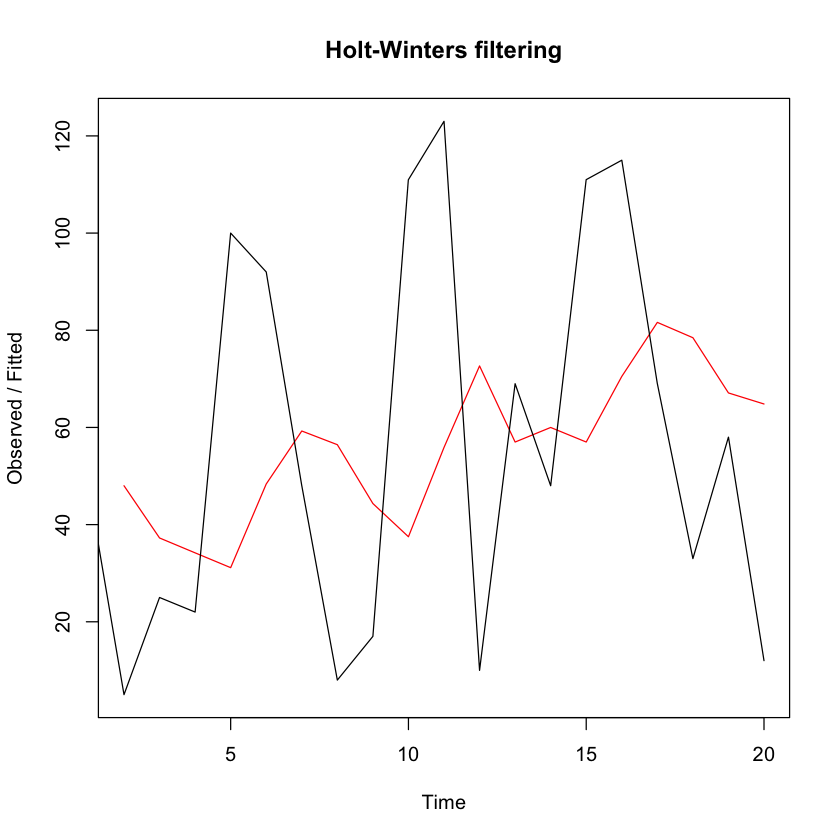

In [62]:
plot(hs)

The black line indicates the means - with just this, it would be very hard to determine a change.  

Instead of worrying about the dates themselves, we can just look at the return values of our defined CUSUM functions since they just represent how many days from July 1 summer ends.  
With a lowered alpha value, we assume that there is relatively more randomness in the data. Mathematically, this also means that we are weighting earlier data points as more important in determining the next value - the next value being if we predicted the unofficial end of summer date for next year.  
  
On a side note - having alpha = 0.0001 ends up with a pretty much just straight line, no matter what parameters we use for the CUSUM. This means that lower alpha acts as if there is much more randomness and, with a value as extremely low as 0.0001, will take the randomness to overpower any trend in the observed data. Basically, the observed data has no weight.  

For this, even with a low alpha value it looks like there is definitely a trend of later summers over the 20 years. 